<a href="https://colab.research.google.com/github/abhi99-ut/aih/blob/main/AIH_SL_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context

**Objective:**
  *   To Develop a Classification Model that can accurately classify patients outcomes based on early clinical notes

**Business Value:**
  *   Early identification of high risk patients based on initial 48 hrs observation

  *   Improved Resource allocation and Treatment planning


*   Enhanced Patents Care and Operational efficiency

**Summary:**

*  Predicting patient outcomes from early clinical notes can enhance decision-making processes, optimize resource allocation, improve patient care, and reduce costs, ultimately contributing to better healthcare delivery and patient satisfaction.













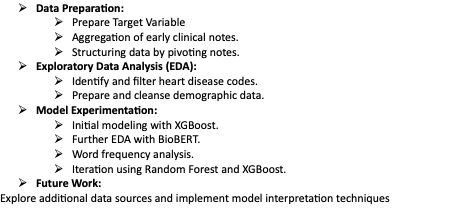

# Data Preparation

Dataset used: MIMIC III

Data Prep Steps:

Created All patients outcome dataset:

1.   Where outcome is grouped into Favorable,Intermediate Care, Adverse, Other.
2.   Extracted the notes generated within 48 hours of admit.
1.   Pivot the notes and join it with dataset of step 1 to have final dataset

Why have I excluded discharge summary?
Objective of my exercise is to classify the outcom based on events and observation that happened in initial 48 hours( even better if we look at 24 hrs). It is important to not include any discharge summary if any as it would leakage of outcome inforamtion in the model.



**Query for Reference:**
**Query 1:**
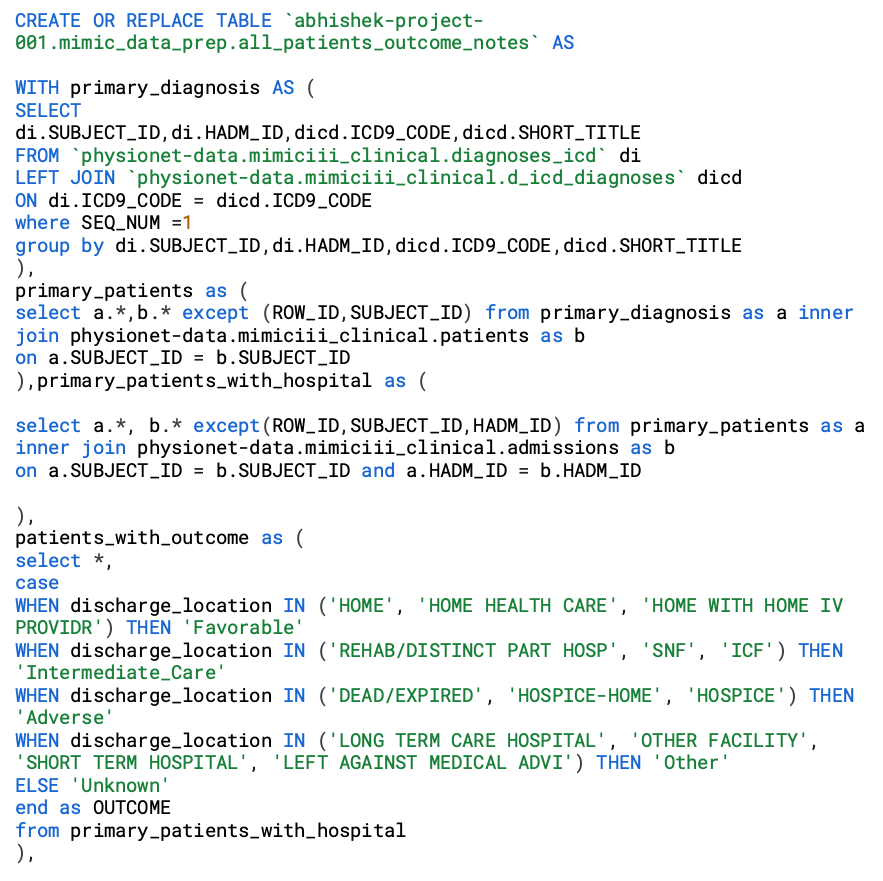

**Query 2**
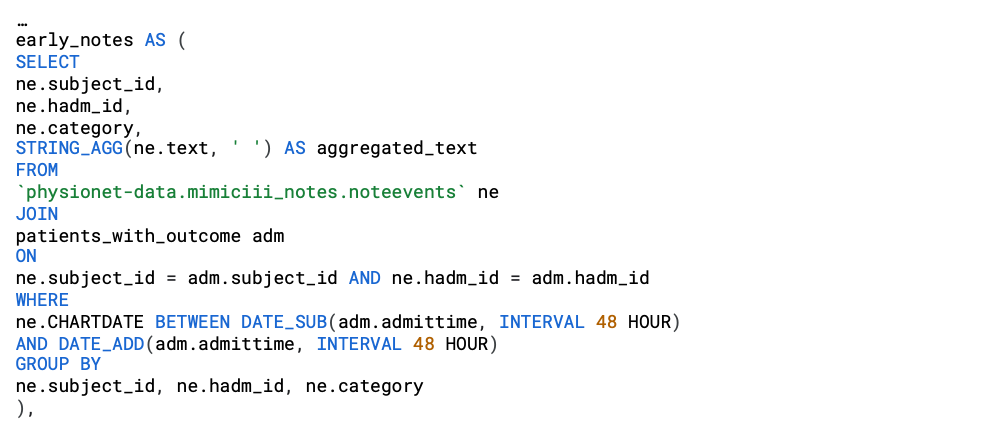


**Query 3**
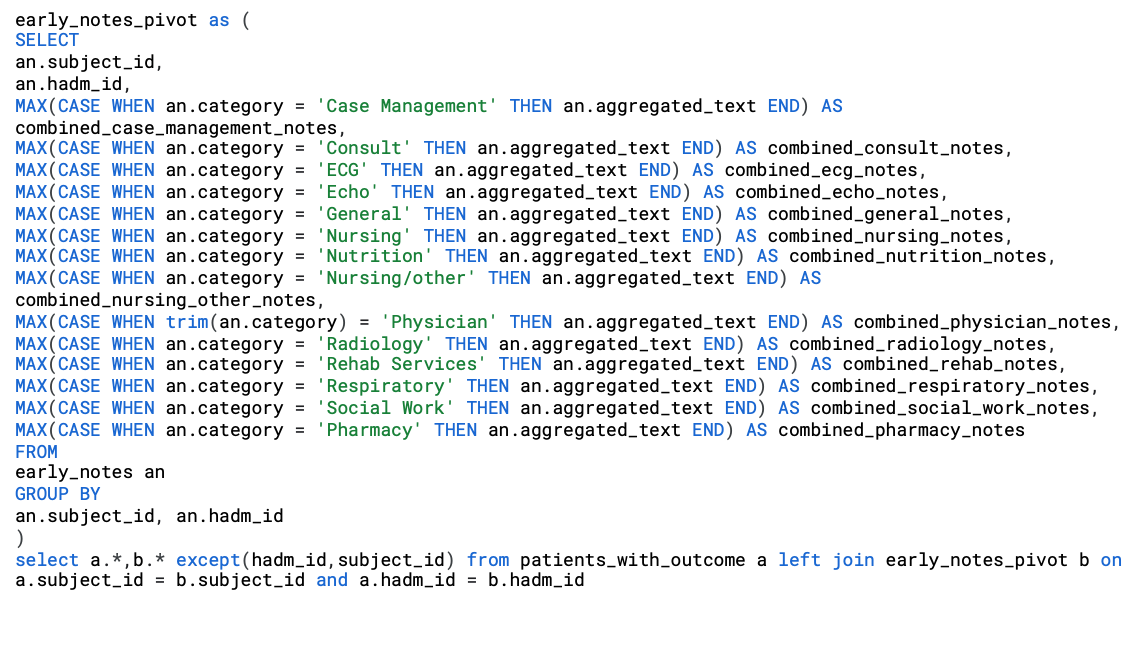





## Import Modules

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import tqdm

# General Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk

# Sklearn Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Transformers Libraries
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
# Set your project ID here
project_id = "xxxxxx-xxx"
client = bigquery.Client(project=project_id)

In [ ]:
query = """
SELECT *
FROM `abhishek.mimic_data_prep.all_patients_outcome_notes`
"""

In [ ]:
#run query
df = client.query(query).to_dataframe()

## Read Data

Data was prepaired and stored in GBQ, Next step was to read the data in the notebook and start with the EDA.


In [ ]:
df.head()


,SUBJECT_ID,HADM_ID,ICD9_CODE,SHORT_TITLE,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,OUTCOME,combined_case_management_notes,combined_consult_notes,combined_ecg_notes,combined_echo_notes,combined_general_notes,combined_nursing_notes,combined_nutrition_notes,combined_nursing_other_notes,combined_physician_notes,combined_radiology_notes,combined_rehab_notes,combined_respiratory_notes,combined_social_work_notes,combined_pharmacy_notes
0,41976,149469,0389,Septicemia NOS,M,2136-07-28,2202-12-05,NaT,2202-12-05,1,2202-09-16 21:56:00,2202-09-23 16:20:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,SPAN,CATHOLIC,MARRIED,HISPANIC/LATINO - PUERTO RICAN,2202-09-16 18:24:00,2202-09-16 23:35:00,SEPSIS,0,1,Intermediate_Care,None,None,Sinus rhythm. Left axis deviation. Right bun...,None,None,None,None,None,None,[**2202-9-16**] 6:40 PM\n CHEST (PORTABLE AP) ...,None,None,None,None
1,44820,175435,0389,Septicemia NOS,M,2110-04-18,NaT,NaT,NaT,0,2197-12-03 16:17:00,2197-12-11 14:19:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2197-12-03 12:44:00,2197-12-03 17:45:00,ALTERED MENTAL STATUS,0,1,Intermediate_Care,None,None,Sinus rhythm. Atrial premature beats and ventr...,None,None,None,None,None,None,[**2197-12-3**] 12:59 PM\n CHEST (PORTABLE AP)...,None,None,None,None
2,98920,115857,1519,Malig neopl stomach NOS,M,2077-04-13,2161-07-19,NaT,2161-07-19,1,2161-03-17 16:13:00,2161-03-21 17:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,ICF,Medicare,ENGL,UNOBTAINABLE,DIVORCED,WHITE,2161-03-17 13:52:00,2161-03-17 17:12:00,GI BLEED,0,1,Intermediate_Care,None,None,Sinus rhythm at upper limits of normal rate. M...,None,None,"Anemia, acute, secondary to blood loss (Hemorr...",None,None,Chief Complaint: GI Bleed\n 24 Hour Events:\...,[**2161-3-17**] 3:44 PM\n CHEST (PORTABLE AP) ...,None,None,None,None
3,99439,196246,2760,Hyperosmolality,M,2095-01-21,2180-01-29,NaT,2180-01-29,1,2179-11-25 19:30:00,2179-11-29 17:29:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,BLACK/AFRICAN AMERICAN,2179-11-25 15:41:00,2179-11-25 21:11:00,HYPERNATREMIA; UTI; ALTERED MS,0,1,Intermediate_Care,None,None,Atrial flutter with moderate ventricular respo...,None,None,None,None,None,None,[**2179-11-25**] 4:40 PM\n CT HEAD W/O CONTRAS...,None,None,None,None
4,61427,101329,4010,Malignant hypertension,F,2087-05-25,2174-06-05,2174-06-05,2174-06-06,1,2173-10-21 18:03:00,2173-10-22 13:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,ICF,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,2173-10-21 16:00:00,2173-10-22 00:54:00,CHEST PAIN,0,1,Intermediate_Care,None,None,Sinus rhythm. Small R' pattern in lead V1 wit...,PATIENT/TEST INFORMATION:\nIndication: Left ve...,None,86 y/o F h/o HTN and dementia from [**Hospital...,None,None,Chief Complaint: Chest Pain\n HPI:\n The ...,[**2173-10-21**] 4:41 PM\n CHEST (PA & LAT) ...,None,None,None,None


In [ ]:
df.shape

(58929, 41)

In [ ]:
df.describe()

,SUBJECT_ID,HADM_ID,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME,DISCHTIME,DEATHTIME,EDREGTIME,EDOUTTIME,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
count,58929.0,58929.0,58929,22545,15031,19041,58929.0,58929,58929,5824,30873,30873,58929.0,58929.0
mean,33768.246721,149970.501841,2086-10-14 17:06:58.775136,2152-12-23 10:05:42.035929,2152-08-26 05:06:45.482004,2153-01-02 17:42:10.266268,0.382579,2151-03-23 10:47:57.418928,2151-04-02 14:11:55.733849,2151-02-09 18:21:03.100962,2151-04-23 07:14:29.112817,2151-04-23 12:59:08.512291,0.098831,0.973273
min,2.0,100001.0,1800-07-02 00:00:00,2100-06-19 00:00:00,2100-06-19 00:00:00,2100-06-19 00:00:00,0.0,2100-06-07 19:59:00,2100-06-09 17:09:00,2100-06-19 08:15:00,2100-06-07 13:14:00,2100-06-08 00:06:00,0.0,0.0
25%,11999.0,124955.0,2062-08-14 00:00:00,2127-12-13 00:00:00,2127-08-17 00:00:00,2127-12-13 00:00:00,0.0,2126-02-22 14:00:00,2126-03-04 17:08:00,2125-12-17 11:34:30,2126-04-04 19:19:00,2126-04-04 23:50:00,0.0,1.0
50%,24141.0,149986.0,2094-05-26 00:00:00,2152-09-28 00:00:00,2152-03-29 00:00:00,2152-09-30 00:00:00,0.0,2151-01-14 15:41:00,2151-01-29 10:45:00,2150-09-01 02:12:30,2150-12-11 13:32:00,2150-12-11 18:55:00,0.0,1.0
75%,53870.0,174964.0,2122-07-22 00:00:00,2178-03-05 00:00:00,2177-09-29 12:00:00,2178-03-16 00:00:00,1.0,2176-07-14 13:24:00,2176-07-21 15:46:00,2176-03-15 08:13:45,2176-08-25 21:02:00,2176-08-25 23:26:00,0.0,1.0
max,99999.0,199999.0,2201-07-24 00:00:00,2211-06-10 00:00:00,2209-01-08 00:00:00,2211-06-10 00:00:00,1.0,2210-08-17 17:13:00,2210-08-24 19:43:00,2208-02-05 11:45:00,2210-08-17 10:14:00,2210-08-17 18:25:00,1.0,1.0
std,28098.166549,28881.33759,NaN,NaN,NaN,NaN,0.486021,NaN,NaN,NaN,NaN,NaN,0.298437,0.161286


### EDA

Observing the types of notes availilbity for analysis, Most of the notes are missing. Most the ecg and radiology notes are present. Decided to focus on Heart patients only

In [ ]:
def null_proportion(df):

    null_percent = df.isnull().mean() * 100

    return null_percent

In [ ]:
proportion_of_nulls = null_proportion(df)
print(proportion_of_nulls)

SUBJECT_ID                          0.000000
HADM_ID                             0.000000
ICD9_CODE                           1.254051
SHORT_TITLE                         1.254051
GENDER                              0.000000
DOB                                 0.000000
DOD                                61.742096
DOD_HOSP                           74.493034
DOD_SSN                            67.688235
EXPIRE_FLAG                         0.000000
ADMITTIME                           0.000000
DISCHTIME                           0.000000
DEATHTIME                          90.116920
ADMISSION_TYPE                      0.000000
ADMISSION_LOCATION                  0.000000
DISCHARGE_LOCATION                  0.000000
INSURANCE                           0.000000
LANGUAGE                           42.931324
RELIGION                            0.777206
MARITAL_STATUS                     17.161330
ETHNICITY                           0.000000
EDREGTIME                          47.609836
EDOUTTIME 

In [ ]:
heart_disease_codes = [
    '410', '411', '412', '413', '414',  # Ischemic heart disease
    '428',  # Heart failure
    '427',  # Arrhythmias
    '424',  # Valvular disorders
    '425',  # Cardiomyopathy
    '426',  # Conduction disorders
    '402'   # Hypertensive heart disease
]
renal_disease_codes = [
    '580', '581', '582', '583', '584', '585', '586', '587', '588'
]


# Filter the DataFrame
df['is_heart_disease'] = df['ICD9_CODE'].apply(lambda x: any(str(x).startswith(code) for code in heart_disease_codes))
df['is_renal_disease'] = df['ICD9_CODE'].apply(lambda x: any(str(x).startswith(code) for code in renal_disease_codes))


In [ ]:
df.groupby(['OUTCOME','is_heart_disease']).size().sort_values(ascending=False)

,,0
OUTCOME,is_heart_disease,
Favorable,False,25735
Intermediate_Care,False,11301
Favorable,True,7240
Adverse,False,5502
Other,False,3934
Intermediate_Care,True,2880
Unknown,False,1132
Adverse,True,724
Other,True,333


In [ ]:
# select columns
cols_to_sel = ['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'SHORT_TITLE', 'GENDER', 'DOB',
'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'ADMITTIME', 'DISCHTIME',
'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'OUTCOME',
'cleaned_radiology_notes',
'cleaned_ecg_notes', 'cleaned_nursing_other_notes',
'cleaned_nursing_notes', 'cleaned_physician_notes']

In [ ]:
df = df[df['ADMISSION_TYPE']!='NEWBORN'].reset_index(drop=True)

In [ ]:
df['OUTCOME'] = df['OUTCOME'].replace('Unknown', 'Other')

In [ ]:
df.OUTCOME.value_counts()

,count
OUTCOME,
Favorable,26203
Intermediate_Care,14175
Adverse,6162
Other,4526


### Select patientients with Heart Disease

In [ ]:
df = df[df.is_heart_disease==1].reset_index(drop=True)

In [ ]:
df['combined_radiology_notes'][0]

"[**2121-9-5**] 10:15 PM\n CT HEAD W/O CONTRAST                                            Clip # [**Clip Number (Radiology) 94476**]\n Reason: ?ich\n ______________________________________________________________________________\n [**Hospital 2**] MEDICAL CONDITION:\n  History: 65F with h/o cva and ?ams\n REASON FOR THIS EXAMINATION:\n  ?ich\n No contraindications for IV contrast\n ______________________________________________________________________________\n WET READ: JEKh FRI [**2121-9-5**] 11:20 PM\n  no ich; no change from [**2119-4-20**].\n\n WET READ VERSION #1\n ______________________________________________________________________________\n                                 FINAL REPORT\n HISTORY:  55-year-old female with history of CVA, now with altered mental\n status.\n\n STUDY:  CT of the head without contrast; images were acquired in soft tissue\n and bone algorithms.  Coronal and sagittal reformatted images were also\n generated.\n\n COMPARISON:  [**2119-4-20**].\n\n FIN

### Clean Notes data

Looking at the clinical notes, its essential we perform relevant data cleaning steps

In [ ]:
import re
def clean_text(text):
    # Remove PHI markers and non-text elements
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\b\d{1,2}:\d{2}\s?(AM|PM|am|pm)\b', '', text)
    text = re.sub(r'[^a-zA-Z0-9:\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
df['cleaned_radiology_notes'] = df['combined_radiology_notes'].apply(lambda x: clean_text(str(x)))
df['cleaned_ecg_notes'] = df['combined_ecg_notes'].apply(lambda x: clean_text(str(x)))
df['cleaned_nursing_other_notes'] = df['combined_nursing_other_notes'].apply(lambda x: clean_text(str(x)))
df['cleaned_nursing_notes'] = df['combined_nursing_notes'].apply(lambda x: clean_text(str(x)))
df['cleaned_physician_notes'] = df['combined_physician_notes'].apply(lambda x: clean_text(str(x)))


In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,SHORT_TITLE,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,OUTCOME,combined_case_management_notes,combined_consult_notes,combined_ecg_notes,combined_echo_notes,combined_general_notes,combined_nursing_notes,combined_nutrition_notes,combined_nursing_other_notes,combined_physician_notes,combined_radiology_notes,combined_rehab_notes,combined_respiratory_notes,combined_social_work_notes,combined_pharmacy_notes,is_heart_disease,is_renal_disease,cleaned_radiology_notes,cleaned_ecg_notes,cleaned_nursing_other_notes,cleaned_nursing_notes,cleaned_physician_notes
0,73686,120933,42731,Atrial fibrillation,F,2056-02-21,NaT,NaT,NaT,0,2121-09-05 23:50:00,2121-09-15 14:01:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,2121-09-05 21:52:00,2121-09-06 01:15:00,PNEUMONIA,0,1,Intermediate_Care,None,None,Atrial fibrillation. Borderline left ventricu...,None,None,None,None,None,None,[**2121-9-5**] 10:15 PM\n CT HEAD W/O CONTRAST...,None,None,None,None,True,False,CT HEAD WO CONTRAST Clip Reason: ich MEDICAL C...,Atrial fibrillation Borderline left ventricula...,None,None,None
1,57036,162444,42789,Cardiac dysrhythmias NEC,F,2106-03-17,2192-10-21,NaT,2192-10-21,1,2191-03-01 17:38:00,2191-03-02 11:00:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,ENGL,JEWISH,WIDOWED,WHITE,2191-03-01 13:02:00,2191-03-01 18:40:00,HYPOTENSION,0,1,Intermediate_Care,None,None,Normal sinus rhythm with atrio-ventricular con...,PATIENT/TEST INFORMATION:\nIndication: hypoten...,None,None,None,None,None,[**2191-3-1**] 4:00 PM\n CTA CHEST W&W/O C&REC...,None,None,None,None,True,False,CTA CHEST WWO CRECONS NONCORONARY CTA ABD WWO ...,Normal sinus rhythm with atrioventricular cond...,None,None,None
2,70476,118218,42843,Ac/chr syst/dia hrt fail,M,2051-09-30,2133-06-27,2133-06-27,2133-06-27,1,2133-05-14 18:54:00,2133-05-23 18:34:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,2133-05-14 16:25:00,2133-05-14 21:40:00,PNEUMONIA,0,1,Intermediate_Care,None,None,Atrial fibrillation with a rapid ventricular r...,None,None,None,None,None,None,"[**Last Name (LF) **],[**First Name3 (LF) 1783...",None,None,None,None,True,False,MED MICU CT HEAD WO CONTRAST Clip Reason: rule...,Atrial fibrillation with a rapid ventricular r...,None,None,None
3,29530,115144,4240,Mitral valve disorder,F,2026-01-20,2102-09-30,2102-09-30,2102-09-30,1,2102-04-13 08:00:00,2102-04-17 14:57:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,NaT,NaT,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,0,1,Intermediate_Care,None,None,Probable accelerated junctional rhythm with ST...,PATIENT/TEST INFORMATION:\nIndication: Intra-o...,None,None,None,"Neuro: A&O x3, forgetful @ times, need constan...",None,[**2102-4-13**] 1:34 PM\n CHEST PORT. LINE PLA...,None,None,None,None,True,False,CHEST PORT LINE PLACEMENT Clip Reason: postop ...,Probable accelerated junctional rhythm with ST...,Neuro: AO x3 forgetful times need constant reo...,None,None
4,97770,159554,4240,Mitral valve disorder,M,2050-01-07,NaT,NaT,NaT,0,2107-06-14 07:15:00,2107-06-21 15:30:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Private,ENGL,OTHER,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,Intermediate_Care,None,None,Sinus rhythm. Within normal limits. Compared...,PATIENT/TEST INFORMATION:\nIndication: MVR/CAB...,None,None,None,None,None,[**2107-6-14**] 1:19 PM\n CHEST PORT. LINE PLA...,None,None,None,None,True,False,CHEST PORT LINE PLACEMENT Clip Reason: FAST TR...,Sinus rhythm Within normal limits Compared to ...,None,None,None


In [ ]:
df.cleaned_radiology_notes[6014]

'CHEST PA LAT Clip Reason: ro ptx assess effusion MEDICAL CONDITION: 66 year old man sp cabg and ct removal REASON FOR THIS EXAMINATION: ro ptx assess effusion FINAL REPORT CHEST TWO VIEWS PA AND LATERAL HISTORY: CABG and chest tube removal Status post CABG There is a left pleural effusion and atelectasisconsolidation in the left lower lobe No pneumothorax'

In [ ]:
df.shape

(11325, 48)

In [ ]:
df= df[cols_to_sel].copy()

## Load Bio-Bert

In this modulde I wanted to leverage bio bert for fine tuning and training other classifiers

In [ ]:
# Load ClinicalBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=4)  # Adjust num_labels for your classes


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


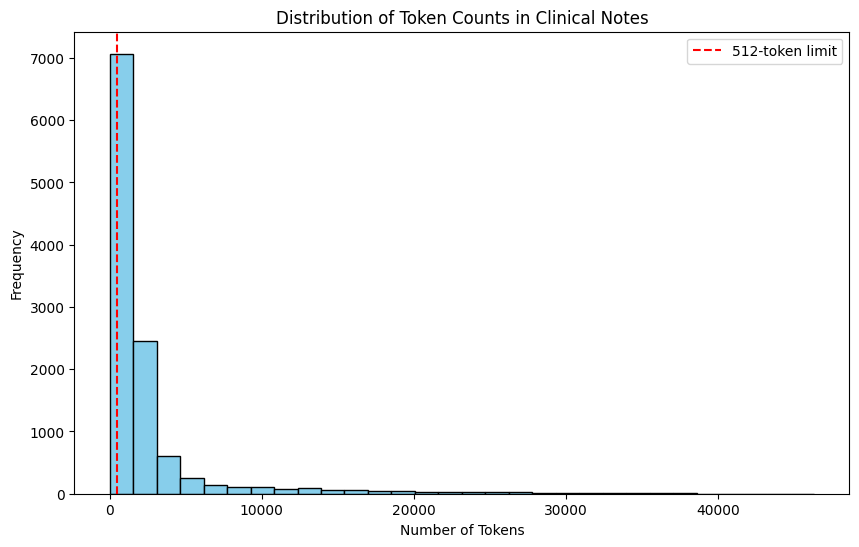

count    11325.000000
mean      2484.037881
std       4556.375118
min          7.000000
25%        535.000000
50%       1143.000000
75%       2171.000000
max      46336.000000
Name: token_count, dtype: float64
Number of clinical notes exceeding 512 tokens: 8597


In [ ]:



# Function to count tokens in a clinical note
def count_tokens(text):
    tokens = tokenizer.encode(text, truncation=False)
    return len(tokens)

# Apply the function to count tokens for each clinical note
df['token_count'] = df['combined_notes'].apply(count_tokens)

# Plot the di?stribution of token counts
plt.figure(figsize=(10, 6))
plt.hist(df['token_count'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', label='512-token limit')
plt.title('Distribution of Token Counts in Clinical Notes')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print summary statistics
print(df['token_count'].describe())

# Count how many notes exceed 512 tokens
num_exceeding_512 = (df['token_count'] > 512).sum()
print(f"Number of clinical notes exceeding 512 tokens: {num_exceeding_512}")


Above mode has the token limit of 512 , in the earlier steps I combines all the available notes, looking at the distribution of token , most of the notes exceeds that, this requires the notes shall be chunked and precomputed for better performance and getting all the context

In [ ]:
#df[['OUTCOME','cleaned_radiology_notes','cleaned_ecg_notes',	'cleaned_nursing_other_notes',	'cleaned_nursing_notes',	'cleaned_physician_notes']].to_csv('clinical_notes.csv', index=False)

In [ ]:
df.combined_notes[5781]

'CHEST PORTABLE AP Clip Reason: eval for pulm edema Admitting Diagnosis: CHEST PAIN MEDICAL CONDITION: 67 year old man with chest pain SOB BLE edema REASON FOR THIS EXAMINATION: eval for pulm edema FINAL REPORT INDICATION: Followup COMPARISON: FINDINGS: In comparison to the previous radiograph of there is no relevant change Status after CABG Moderate enlargement of the cardiac silhouette with tortuosity of the thoracic aorta Similar lordotic positioning as in the previous examination The structure of the lungs is normal There is no evidence of fluid overload or of cardiac decompensation No pleural effusions no parenchymal opacities suggestive of pneumonia The hilar and mediastinal contours are unremarkable IMPRESSION: Moderate cardiomegaly after CABG no evidence of pleural effusion no pneumonia DR DR CHEST PORTABLE AP Clip Reason: please assess for acute process MEDICAL CONDITION: 67 year old man with cp REASON FOR THIS EXAMINATION: please assess for acute process FINAL REPORT IINDICAT

## Split Chunk as the context is greater than 512

In [ ]:
# Combine relevant text columns into a single 'combined_notes' column
text_columns = ['cleaned_radiology_notes', 'cleaned_ecg_notes', 'cleaned_nursing_other_notes',
                'cleaned_nursing_notes', 'cleaned_physician_notes']
df['combined_notes'] = df[text_columns].fillna('').agg(' '.join, axis=1)

# Encode target variable
label_mapping = {label: idx for idx, label in enumerate(df['OUTCOME'].unique())}
df['outcome_encoded'] = df['OUTCOME'].map(label_mapping)

# Load ClinicalBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Function to split text into chunks and tokenize each chunk
def tokenize_text_into_chunks(text, tokenizer, max_length=512, stride=256):
    tokenized_chunks = tokenizer(
        text,
        return_tensors='pt',
        max_length=max_length,
        truncation=True,
        stride=stride,
        padding=False,
        return_overflowing_tokens=True
    )

    chunks = []
    for i in range(tokenized_chunks['input_ids'].shape[0]):
        chunks.append({
            'input_ids': tokenized_chunks['input_ids'][i],
            'attention_mask': tokenized_chunks['attention_mask'][i]
        })
    return chunks

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Dataset

 for finetuning bio-bert

In [ ]:
# Custom dataset class for PyTorch
class ClinicalNotesDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        note = self.df.iloc[idx]['combined_notes']
        outcome = self.df.iloc[idx]['outcome_encoded']
        chunks = tokenize_text_into_chunks(note, self.tokenizer)

        return {
            'chunks': chunks,
            'label': torch.tensor(outcome, dtype=torch.long)
        }

## Data Loader

for finetuning bio bert

In [ ]:
# Custom collate function to handle variable-length chunks
def custom_collate_fn(batch):
    collated_batch = {
        'chunks': [item['chunks'] for item in batch],
        'label': torch.stack([item['label'] for item in batch])
    }
    return collated_batch

# Stratified split of the dataset
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df['outcome_encoded']):
    train_dataset = ClinicalNotesDataset(df.iloc[train_idx], tokenizer)
    test_dataset = ClinicalNotesDataset(df.iloc[test_idx], tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)


In [ ]:

# Load ClinicalBERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(label_mapping))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Tune Bio-Bert

In [ ]:
# Compute class weights for imbalanced dataset
class_counts = df['outcome_encoded'].value_counts()
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize weights
weights = torch.tensor(class_weights.values, dtype=torch.float).to(device)

# Define weighted cross-entropy loss
criterion = torch.nn.CrossEntropyLoss(weight=weights)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop with F1-score evaluation
epochs = 20  # Set higher epochs to allow early stopping to work effectively
early_stopping_patience = 3
best_val_f1 = 0  # Track the best F1-score
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training loop
    for batch in train_loader:
        model.zero_grad()
        batch_loss = 0

        # Process each chunk in the batch
        for chunk_set in batch['chunks'][0]:
            input_ids = chunk_set['input_ids'].unsqueeze(0).to(device)
            attention_mask = chunk_set['attention_mask'].unsqueeze(0).to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            batch_loss += loss

        # Average the loss over all chunks and perform backpropagation
        batch_loss /= len(batch['chunks'][0])
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch_val_loss = 0

            for chunk_set in batch['chunks'][0]:
                input_ids = chunk_set['input_ids'].unsqueeze(0).to(device)
                attention_mask = chunk_set['attention_mask'].unsqueeze(0).to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                batch_val_loss += loss.item()

                # Collect predictions and labels for F1-score calculation
                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            batch_val_loss /= len(batch['chunks'][0])
            val_loss += batch_val_loss

    avg_val_loss = val_loss / len(test_loader)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')  # Use weighted F1-score
    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Weighted F1-Score: {val_f1:.4f}')

    # Early stopping condition based on F1-score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0  # Reset the counter if F1-score improves
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
    else:
        patience_counter += 1
        print(f'No improvement in F1-score for {patience_counter} epochs.')

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Load the best model after early stopping
model.load_state_dict(torch.load('best_model.pt'))


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.

Epoch 1/20, Training Loss: 1.0400
Epoch 1/20, Validation Loss: 0.9744, Weighted F1-Score: 0.4875
Epoch 2/20, Training Loss: 0.9967
Epoch 2/20, Validation Loss: 0.9773, Weighted F1-Score: 0.4875
No improvement in F1-score for 1 epochs.
Epoch 3/20, Training Loss: 0.9825
Epoch 3/20, Validation Loss: 0.9949, Weighted F1-Score: 0.4875
No improvement in F1-score for 2 epochs.
Epoch 4/20, Training Loss: 1.0016
Epoch 4/20, Validation Loss: 0.9674, Weighted F1-Score: 0.4875
No improvement in F1-score for 3 epochs.
Early stopping triggered.


<ipython-input-36-f198558af026>:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [ ]:


# Ensure you have the NLTK stopwords downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load stopwords
stop_words = set(stopwords.words('english'))

# Filter text data for Adverse and Favorable classes
adverse_texts = df[df['OUTCOME'] == 'Adverse']['combined_notes'].str.lower().tolist()
favorable_texts = df[df['OUTCOME'] == 'Favorable']['combined_notes'].str.lower().tolist()

# Tokenize and clean text (remove stopwords and non-alphabetic characters)
def tokenize_and_clean(texts):
    tokens = []
    for text in texts:
        words = [word for word in text.split() if word.isalpha() and word not in stop_words]
        tokens.extend(words)
    return tokens

adverse_tokens = tokenize_and_clean(adverse_texts)
favorable_tokens = tokenize_and_clean(favorable_texts)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


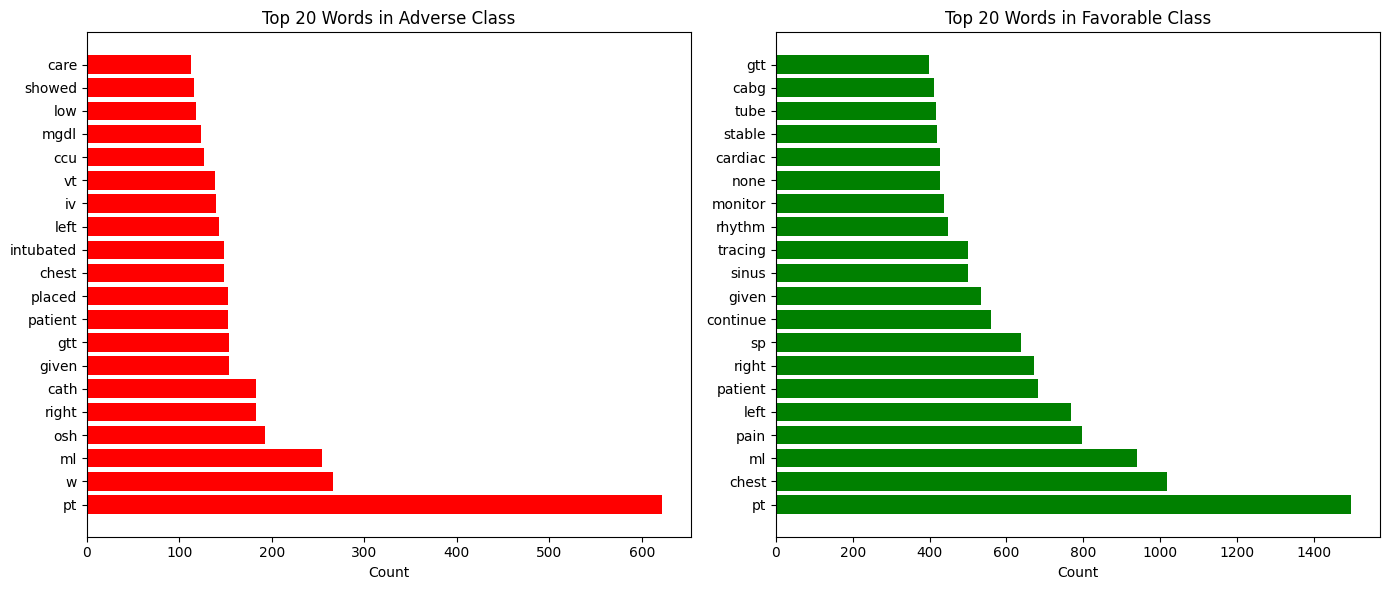

In [ ]:
# Count word frequencies
adverse_word_counts = Counter(adverse_tokens)
favorable_word_counts = Counter(favorable_tokens)

# Get the most common words in each class
adverse_common_words = adverse_word_counts.most_common(20)
favorable_common_words = favorable_word_counts.most_common(20)

# Convert to DataFrame for easy visualization
adverse_df = pd.DataFrame(adverse_common_words, columns=['word', 'count'])
favorable_df = pd.DataFrame(favorable_common_words, columns=['word', 'count'])

# Plot bar charts
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(adverse_df['word'], adverse_df['count'], color='red')
plt.title('Top 20 Words in Adverse Class')
plt.xlabel('Count')

plt.subplot(1, 2, 2)
plt.barh(favorable_df['word'], favorable_df['count'], color='green')
plt.title('Top 20 Words in Favorable Class')
plt.xlabel('Count')

plt.tight_layout()
plt.show()


## Experiments

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,SHORT_TITLE,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,OUTCOME,cleaned_radiology_notes,cleaned_ecg_notes,cleaned_nursing_other_notes,cleaned_nursing_notes,cleaned_physician_notes
1250,25905,109087,4240,Mitral valve disorder,F,2112-06-22,2188-07-27,2188-07-27,NaT,1,2179-09-07 08:00:00,2179-09-13 17:56:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,None,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaT,NaT,CORONARY ARTERY DISEASE;MR\CORONARY ARTERY BYP...,0,1,Favorable,None,Sinus rhythm Vertical axis for age Right bundl...,Poor CI through out nite 161187 despite LR x 5...,None,None
2816,15781,147487,41401,Crnry athrscl natve vssl,F,2073-04-30,NaT,NaT,NaT,0,2129-04-08 16:29:00,2129-04-09 16:00:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicare,SPAN,CATHOLIC,SEPARATED,HISPANIC OR LATINO,NaT,NaT,CORONARY ARTERY DISEASE\RIGHT AND LEFT HEART CATH,0,1,Favorable,None,Sinus rhythm Normal ECG Compared to the previo...,06:30 npn addendum: Pts peakflow remains 350 r...,None,None
6014,15934,161329,41401,Crnry athrscl natve vssl,M,2115-11-19,NaT,NaT,NaT,0,2182-09-23 05:55:00,2182-09-28 12:27:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,PROTESTANT QUAKER,None,UNKNOWN/NOT SPECIFIED,NaT,NaT,CORONARY ARTERY DISEASE/SDA,0,1,Favorable,CHEST PA LAT Clip Reason: ro ptx assess effusi...,Regular rhythm with unusual P axis rate 57 Inf...,Neuro: MAE to command Shakesnods head appropri...,None,None
5781,30625,174427,41071,"Subendo infarct, initial",M,2051-09-02,NaT,NaT,NaT,0,2119-01-16 00:49:00,2119-01-20 13:22:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2119-01-15 23:42:00,2119-01-16 02:14:00,CHEST PAIN,0,1,Favorable,CHEST PORTABLE AP Clip Reason: eval for pulm e...,Sinus rhythm First degree AV conduction delay ...,CCU NPN 07001900 S: I can do itI felt like thi...,None,None
10521,8273,188483,42831,Ac diastolic hrt failure,M,2065-12-31,NaT,NaT,NaT,0,2133-07-06 17:50:00,2133-07-12 14:49:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,DYSPNEA;RULE OUT PULMONARY HYPERTENSION\RIGHT ...,0,1,Favorable,CHEST PORTABLE AP Clip Reason: assess interval...,Sinus rhythm and atrial ectopy atrial bigeminy...,None,None,None


In [ ]:
text_columns = ['cleaned_radiology_notes', 'cleaned_ecg_notes', 'cleaned_nursing_other_notes',
                'cleaned_nursing_notes', 'cleaned_physician_notes']
df['combined_notes'] = df[text_columns].fillna('').agg(' '.join, axis=1)

In [ ]:
relevant_data = df[['combined_notes', 'OUTCOME']].reset_index(drop=True)

In [ ]:
relevant_data.head()

,combined_notes,OUTCOME
0,CT HEAD WO CONTRAST Clip Reason: ich MEDICAL C...,Intermediate_Care
1,CTA CHEST WWO CRECONS NONCORONARY CTA ABD WWO ...,Intermediate_Care
2,MED MICU CT HEAD WO CONTRAST Clip Reason: rule...,Intermediate_Care
3,CHEST PORT LINE PLACEMENT Clip Reason: postop ...,Intermediate_Care
4,CHEST PORT LINE PLACEMENT Clip Reason: FAST TR...,Intermediate_Care


In [ ]:
relevant_data.OUTCOME.value_counts()

,count
OUTCOME,
Favorable,7240
Intermediate_Care,2880
Adverse,724
Other,481


### Experiment 1: Train RF and XGboost using TF-IDF vectoriser

In [ ]:
# import Tfidf


X_train, X_test, y_train, y_test = train_test_split(
    df['combined_notes'],
    df['OUTCOME'],
    test_size=0.2,
    random_state=42,
    stratify=df['OUTCOME']
)

# TF-IDF transformation
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Encode categorical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train a Random Forest classifier with class weights
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_classifier.fit(X_train_tfidf, y_train_encoded)

# Calculate scale_pos_weight for XGBoost
minority_class = y_train.value_counts().idxmin()
majority_class = y_train.value_counts().idxmax()
scale_pos_weight = len(y_train[y_train == majority_class]) / len(y_train[y_train == minority_class])

# Train an XGBoost classifier with adjusted scale_pos_weight
xgb_classifier = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_classifier.fit(X_train_tfidf, y_train_encoded)

# Predictions and evaluation
y_pred_rf = rf_classifier.predict(X_test_tfidf)
y_pred_xgb = xgb_classifier.predict(X_test_tfidf)

# Decode the predictions
y_pred_rf_decoded = label_encoder.inverse_transform(y_pred_rf)
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate models
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_decoded))
print(classification_report(y_test, y_pred_rf_decoded))

print("\nXGBoost Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_decoded))
print(classification_report(y_test, y_pred_xgb_decoded))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:35:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Classifier:
Accuracy: 0.6485651214128035
                   precision    recall  f1-score   support

          Adverse       0.66      0.16      0.26       145
        Favorable       0.65      0.98      0.78      1448
Intermediate_Care       0.47      0.04      0.07       576
            Other       0.00      0.00      0.00        96

         accuracy                           0.65      2265
        macro avg       0.44      0.30      0.28      2265
     weighted avg       0.58      0.65      0.54      2265


XGBoost Classifier:
Accuracy: 0.6777041942604857
                   precision    recall  f1-score   support

          Adverse       0.71      0.23      0.35       145
        Favorable       0.72      0.91      0.80      1448
Intermediate_Care       0.49      0.32      0.38       576
            Other       0.00      0.00      0.00        96

         accuracy                           0.68      2265
        macro avg       0.48      0.37      0.38      2265
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Summary of above experiment:**

Experiment on patient notes classification is using tf-idf vectorizer, I iterated with Random Forest and Xgboost. Xgboost shows promise if having a better recall and precision. This clearly outperforms the 1st iteration with limited features using pt demographics. Let see if this could be further improved with using pre-trained embeddings

#### Grid Search

In [ ]:


# Fine-tuning XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]  # Calculated previously based on class imbalance
}

xgb_grid_search = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='recall_macro',  # Focusing on improving recall for the minority class
    cv=3,
    n_jobs=-1
)
xgb_grid_search.fit(X_train_tfidf, y_train_encoded)

# Best parameters for XGBoost
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)

# Re-train the best model for XGBoost
best_xgb_model = xgb_grid_search.best_estimator_

# Generate predictions using the best model
y_pred_xgb = best_xgb_model.predict(X_test_tfidf)

# Decode predictions
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Confusion Matrix and Classification Report for XGBoost
conf_matrix = confusion_matrix(y_test, y_pred_xgb_decoded)

# Define class labels (adjust based on your dataset)
class_labels = ['Adverse', 'Favorable', 'Intermediate_Care', 'Other']

# Plot the confusion matrix using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Add tick marks and labels
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add annotations inside the confusion matrix
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()

# Print the classification report with class labels
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb_decoded, target_names=class_labels))

plt.show()


** Grid search was time consuming **

### Experiment 2: DNN



In [ ]:
# Load BioBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
biobert_model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
biobert_model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
clinical_notes_df = df

# Combine relevant columns into a single text input
clinical_notes_df['combined_notes'] = clinical_notes_df[
    ['cleaned_radiology_notes', 'cleaned_ecg_notes',
     'cleaned_nursing_other_notes', 'cleaned_nursing_notes',
     'cleaned_physician_notes']
].fillna('').agg(' '.join, axis=1)

# Encode outcomes as labels
outcome_mapping = {outcome: idx for idx, outcome in enumerate(clinical_notes_df['OUTCOME'].unique())}
clinical_notes_df['label'] = clinical_notes_df['OUTCOME'].map(outcome_mapping)


In [ ]:
clinical_notes_df.shape

(11325, 50)

#### Load tokeninzer

In [ ]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load BioBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
biobert_model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1").to(device)
biobert_model.eval()



Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Function to split long texts into chunks
def split_into_chunks(text, tokenizer, max_length=512):
    tokens = tokenizer.tokenize(text)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return [" ".join(chunk) for chunk in chunks]

In [ ]:
# Combine relevant columns into a single text input
clinical_notes_df['combined_notes'] = clinical_notes_df[
    ['cleaned_radiology_notes', 'cleaned_ecg_notes',
     'cleaned_nursing_other_notes', 'cleaned_nursing_notes',
     'cleaned_physician_notes']
].fillna('').agg(' '.join, axis=1)

# Encode outcomes as labels
outcome_mapping = {outcome: idx for idx, outcome in enumerate(clinical_notes_df['OUTCOME'].unique())}
clinical_notes_df['label'] = clinical_notes_df['OUTCOME'].map(outcome_mapping)

# Stratified split for train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    clinical_notes_df['combined_notes'],
    clinical_notes_df['label'],
    test_size=0.2,  # 20% of the data for validation
    stratify=clinical_notes_df['label'],
    random_state=42
)


#### Pre compute embeddings

To have better performance during training it is essential that we precompute and save the embeddings. This will enable a quick training and validation



In [ ]:
%%time
def precompute_embeddings(texts, tokenizer, model, max_length=512, device='cpu'):
    embeddings_list = []
    with torch.no_grad():
        for text in texts:
            chunks = split_into_chunks(text, tokenizer, max_length=max_length)
            all_embeddings = []
            for chunk in chunks:
                encoded_input = tokenizer(
                    chunk,
                    padding='max_length',
                    truncation=True,
                    max_length=max_length,
                    return_tensors='pt'
                ).to(device)
                output = model(
                    input_ids=encoded_input['input_ids'],
                    attention_mask=encoded_input['attention_mask']
                )
                cls_embedding = output.last_hidden_state[:, 0, :].to(device)
                all_embeddings.append(cls_embedding)

            combined_embedding = torch.mean(torch.stack(all_embeddings), dim=0)
            embeddings_list.append(combined_embedding.squeeze(0).cpu())  # Move to CPU to save memory

    return torch.stack(embeddings_list)

# Precompute and save embeddings
train_embeddings = precompute_embeddings(train_texts, tokenizer, biobert_model, device=device)
val_embeddings = precompute_embeddings(val_texts, tokenizer, biobert_model, device=device)

# Save to disk if needed
torch.save(train_embeddings, 'train_embeddings.pt')
torch.save(val_embeddings, 'val_embeddings.pt')


CPU times: user 30min 6s, sys: 3.19 s, total: 30min 9s
Wall time: 30min 22s


In [ ]:
class ClinicalNotesDataset(Dataset):
    def __init__(self, embeddings, labels, device='cpu'):
        self.embeddings = embeddings
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx].to(self.device)
        label = torch.tensor(self.labels[idx], dtype=torch.long).to(self.device)
        return {'embedding': embedding, 'label': label}


#### MLP

In [ ]:
# Define the DNN model
class DNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
model = DNNClassifier(input_dim, hidden_dim, num_classes).to(device)


In [ ]:
# Load precomputed embeddings
train_embeddings = torch.load('train_embeddings.pt').to(device)
val_embeddings = torch.load('val_embeddings.pt').to(device)

train_dataset = ClinicalNotesDataset(train_embeddings, train_labels.tolist(), device=device)
val_dataset = ClinicalNotesDataset(val_embeddings, val_labels.tolist(), device=device)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Instantiate the model and move it to GPU
input_dim = 768  # BioBERT's hidden size
hidden_dim = 128
num_classes = len(outcome_mapping)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 10
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
patience_counter = 0

In [ ]:
# Training and validation loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for batch in train_dataloader:
        embeddings = batch['embedding']
        labels = batch['label']

        # Forward pass
        outputs = model(embeddings)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_dataloader:
            embeddings = batch['embedding']
            labels = batch['label']
            outputs = model(embeddings)
            val_loss += criterion(outputs, labels).item()
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataloader)
    val_accuracy = correct / total

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item():.4f},
    Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter when improvement is seen
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break
# Load the best model before evaluation or deployment
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)  # Ensure the best model is on the GPU
print("Loaded the best model with validation loss:", best_val_loss)
print("Outcome mapping:", outcome_mapping)

<ipython-input-64-4230f6d19aff>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load('train_embeddings.pt').to(device)
<ipython-input-64-4230f6d19a

Epoch 1/10, Training Loss: 0.9946, Validation Loss: 0.9270, Validation Accuracy: 0.6393
Epoch 2/10, Training Loss: 0.7072, Validation Loss: 0.9070, Validation Accuracy: 0.6402
Epoch 3/10, Training Loss: 0.7487, Validation Loss: 0.9037, Validation Accuracy: 0.6393
Epoch 4/10, Training Loss: 0.7475, Validation Loss: 0.8964, Validation Accuracy: 0.6375
Epoch 5/10, Training Loss: 0.6704, Validation Loss: 0.8887, Validation Accuracy: 0.6406
Epoch 6/10, Training Loss: 0.7515, Validation Loss: 0.8804, Validation Accuracy: 0.6397
Epoch 7/10, Training Loss: 0.9317, Validation Loss: 0.8836, Validation Accuracy: 0.6402
Epoch 8/10, Training Loss: 0.7225, Validation Loss: 0.8824, Validation Accuracy: 0.6512
Epoch 9/10, Training Loss: 0.8748, Validation Loss: 0.9077, Validation Accuracy: 0.6393
Early stopping triggered. Training stopped.
Loaded the best model with validation loss: 0.8804239531358083
Outcome mapping: {'Intermediate_Care': 0, 'Favorable': 1, 'Adverse': 2, 'Other': 3}


<ipython-input-64-4230f6d19aff>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


#### Result

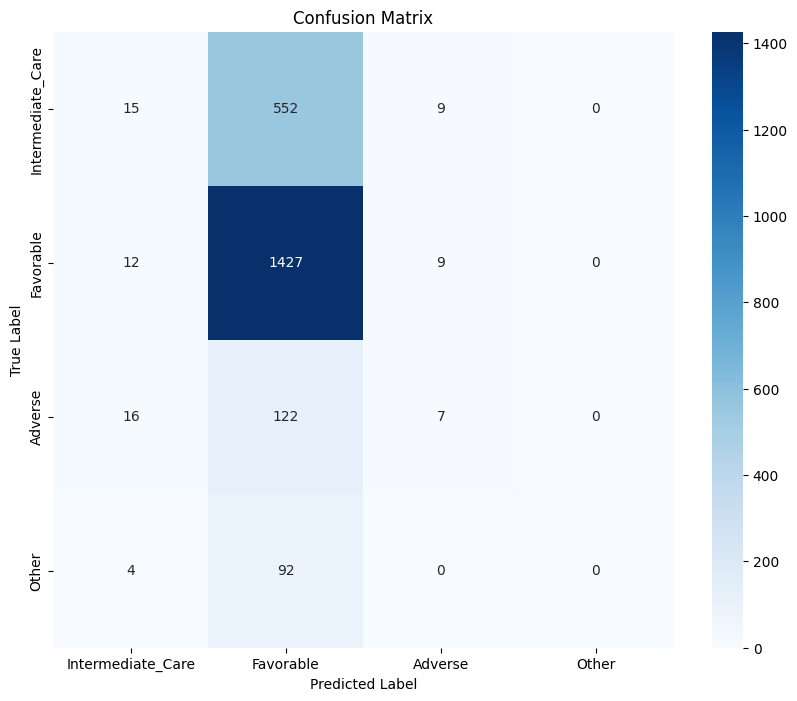

                   precision    recall  f1-score   support

Intermediate_Care       0.32      0.03      0.05       576
        Favorable       0.65      0.99      0.78      1448
          Adverse       0.28      0.05      0.08       145
            Other       0.00      0.00      0.00        96

         accuracy                           0.64      2265
        macro avg       0.31      0.26      0.23      2265
     weighted avg       0.52      0.64      0.52      2265



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# Evaluate the model on the validation set and get predictions
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for batch in val_dataloader:
        embeddings = batch['embedding']
        labels = batch['label']
        outputs = model(embeddings)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=outcome_mapping.keys(), yticklabels=outcome_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more detailed performance metrics
print(classification_report(all_labels, all_preds, target_names=outcome_mapping.keys()))


**Summary**:


Started with simple two layers dnn with relu activation , this doesn’t perform well largely misses the adverse event.

### Experiment 3: Improved DNN

In [ ]:
# Define the DNN model with improvements
class ImprovedDNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.3):
        super(ImprovedDNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [ ]:
## End to end modelling and training loops
# Encode outcomes as labels
outcome_mapping = {outcome: idx for idx, outcome in enumerate(clinical_notes_df['OUTCOME'].unique())}
clinical_notes_df['label'] = clinical_notes_df['OUTCOME'].map(outcome_mapping)

# Stratified split for train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    clinical_notes_df['combined_notes'],
    clinical_notes_df['label'],
    test_size=0.2,
    stratify=clinical_notes_df['label'],
    random_state=42
)

# Load precomputed embeddings
train_embeddings = torch.load('train_embeddings.pt').to(device)
val_embeddings = torch.load('val_embeddings.pt').to(device)

# Create custom dataset class
class ClinicalNotesDataset(Dataset):
    def __init__(self, embeddings, labels, device='cpu'):
        self.embeddings = embeddings
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx].to(self.device)
        label = torch.tensor(self.labels[idx], dtype=torch.long).to(self.device)
        return {'embedding': embedding, 'label': label}

# Prepare DataLoaders
train_dataset = ClinicalNotesDataset(train_embeddings, train_labels.tolist(), device=device)
val_dataset = ClinicalNotesDataset(val_embeddings, val_labels.tolist(), device=device)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Calculate class weights for the loss function
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


# Instantiate the model and move it to GPU
input_dim = 768  # BioBERT's hidden size
hidden_dim = 128
num_classes = len(outcome_mapping)
model = ImprovedDNNClassifier(input_dim, hidden_dim, num_classes, dropout_rate=0.3).to(device)

# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
patience_counter = 0

# Training and validation loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        embeddings = batch['embedding']
        labels = batch['label']

        # Forward pass
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Adjust learning rate
    scheduler.step()

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in val_dataloader:
            embeddings = batch['embedding']
            labels = batch['label']
            outputs = model(embeddings)
            val_loss += criterion(outputs, labels).item()

            # Store predictions for evaluation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct / total

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter when improvement is seen
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Load the best model before evaluation or deployment
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
print("Loaded the best model with validation loss:", best_val_loss)

#### Results

<ipython-input-58-ce41be9bda34>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load('train_embeddings.pt').to(device)
<ipython-input-58-ce41be9bd

Epoch 1/10, Training Loss: 1.3546, Validation Loss: 1.2940, Validation Accuracy: 0.4287
Epoch 2/10, Training Loss: 1.2606, Validation Loss: 1.2667, Validation Accuracy: 0.4344
Epoch 3/10, Training Loss: 1.2113, Validation Loss: 1.2771, Validation Accuracy: 0.5104
Epoch 4/10, Training Loss: 1.1554, Validation Loss: 1.2439, Validation Accuracy: 0.4521
Epoch 5/10, Training Loss: 1.1306, Validation Loss: 1.2400, Validation Accuracy: 0.4313
Epoch 6/10, Training Loss: 1.1065, Validation Loss: 1.2421, Validation Accuracy: 0.4230
Epoch 7/10, Training Loss: 1.0854, Validation Loss: 1.2367, Validation Accuracy: 0.4680
Epoch 8/10, Training Loss: 1.0872, Validation Loss: 1.2357, Validation Accuracy: 0.4640
Epoch 9/10, Training Loss: 1.0760, Validation Loss: 1.2383, Validation Accuracy: 0.4525
Epoch 10/10, Training Loss: 1.0845, Validation Loss: 1.2382, Validation Accuracy: 0.4512
Loaded the best model with validation loss: 1.235716798239284


<ipython-input-58-ce41be9bda34>:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


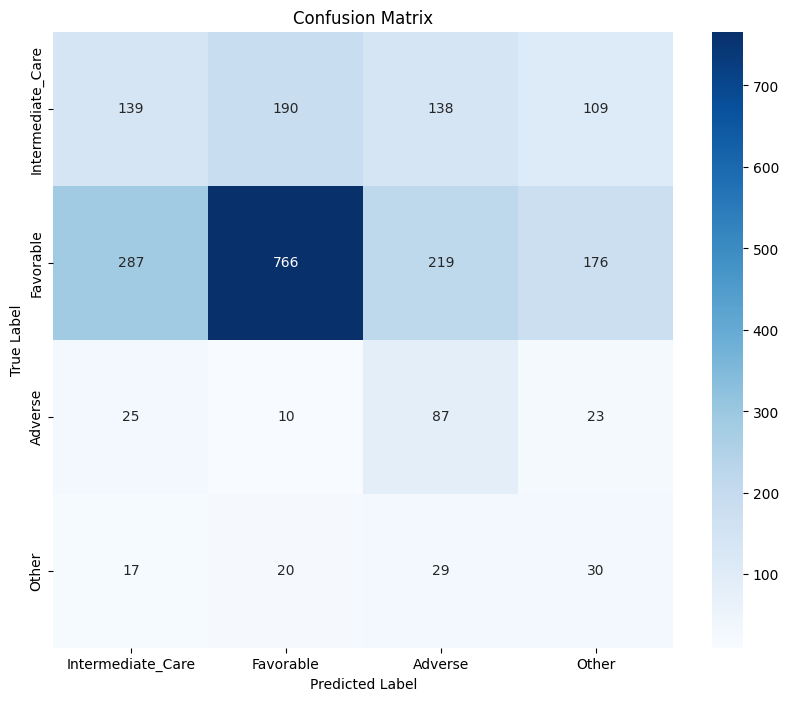

                   precision    recall  f1-score   support

Intermediate_Care       0.30      0.24      0.27       576
        Favorable       0.78      0.53      0.63      1448
          Adverse       0.18      0.60      0.28       145
            Other       0.09      0.31      0.14        96

         accuracy                           0.45      2265
        macro avg       0.34      0.42      0.33      2265
     weighted avg       0.59      0.45      0.49      2265



In [ ]:

# Evaluate with a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=outcome_mapping.keys(), yticklabels=outcome_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(all_labels, all_preds, target_names=outcome_mapping.keys()))



**Summary**
Next iteration : as the data is largely imbalanced I added class weights, improved model architecture to include batch not and deeper nn. Adverse event classification improves and performs best till now, Altough recall has improved but precision remains low. In this case recall could be a better metric to focus if we want to not miss and priortise and identify high risk pt


### Experiment 4: Enchanced MLP

In [ ]:
class EnhancedMLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout_rate=0.3):
        super(EnhancedMLPClassifier, self).__init__()
        self.layers = nn.ModuleList()
        self.num_layers = len(hidden_dims)

        # Create the hidden layers with batch normalization, dropout, and residual connections
        for i in range(self.num_layers):
            if i == 0:
                self.layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.layers.append(nn.BatchNorm1d(hidden_dims[i]))
            self.layers.append(nn.LeakyReLU())
            self.layers.append(nn.Dropout(dropout_rate))

        # Output layer
        self.output_layer = nn.Linear(hidden_dims[-1], num_classes)

    def forward(self, x):
        for i in range(self.num_layers):
            residual = x  # Save the input for residual connection
            x = self.layers[i*4](x)  # Linear layer
            x = self.layers[i*4 + 1](x)  # BatchNorm
            x = self.layers[i*4 + 2](x)  # Activation
            x = self.layers[i*4 + 3](x)  # Dropout

            # Add residual connection if dimensions match
            if x.shape == residual.shape:
                x += residual

        x = self.output_layer(x)
        return x

# Define input and hidden layer sizes
input_dim = 768  # BioBERT embedding size
hidden_dims = [256, 128, 64]  # Decreasing sizes for hidden layers
num_classes = len(outcome_mapping)

# Instantiate the model
model = EnhancedMLPClassifier(input_dim, hidden_dims, num_classes, dropout_rate=0.3).to(device)


In [ ]:
# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
patience_counter = 0

# Training and validation loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        embeddings = batch['embedding']
        labels = batch['label']

        # Forward pass
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Adjust learning rate
    scheduler.step()

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in val_dataloader:
            embeddings = batch['embedding']
            labels = batch['label']
            outputs = model(embeddings)
            val_loss += criterion(outputs, labels).item()

            # Store predictions for evaluation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct / total

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter when improvement is seen
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Load the best model before evaluation or deployment
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
print("Loaded the best model with validation loss:", best_val_loss)

#### Results

Epoch 1/10, Training Loss: 1.3905, Validation Loss: 1.3132, Validation Accuracy: 0.3196
Epoch 2/10, Training Loss: 1.3021, Validation Loss: 1.2897, Validation Accuracy: 0.3320
Epoch 3/10, Training Loss: 1.2482, Validation Loss: 1.2544, Validation Accuracy: 0.4596
Epoch 4/10, Training Loss: 1.2007, Validation Loss: 1.2418, Validation Accuracy: 0.4472
Epoch 5/10, Training Loss: 1.1758, Validation Loss: 1.2449, Validation Accuracy: 0.4419
Epoch 6/10, Training Loss: 1.1787, Validation Loss: 1.2416, Validation Accuracy: 0.4715
Epoch 7/10, Training Loss: 1.1583, Validation Loss: 1.2381, Validation Accuracy: 0.4389
Epoch 8/10, Training Loss: 1.1578, Validation Loss: 1.2377, Validation Accuracy: 0.4605
Epoch 9/10, Training Loss: 1.1502, Validation Loss: 1.2393, Validation Accuracy: 0.4658
Epoch 10/10, Training Loss: 1.1545, Validation Loss: 1.2382, Validation Accuracy: 0.4468
Loaded the best model with validation loss: 1.237713893254598


<ipython-input-74-37602866ad34>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


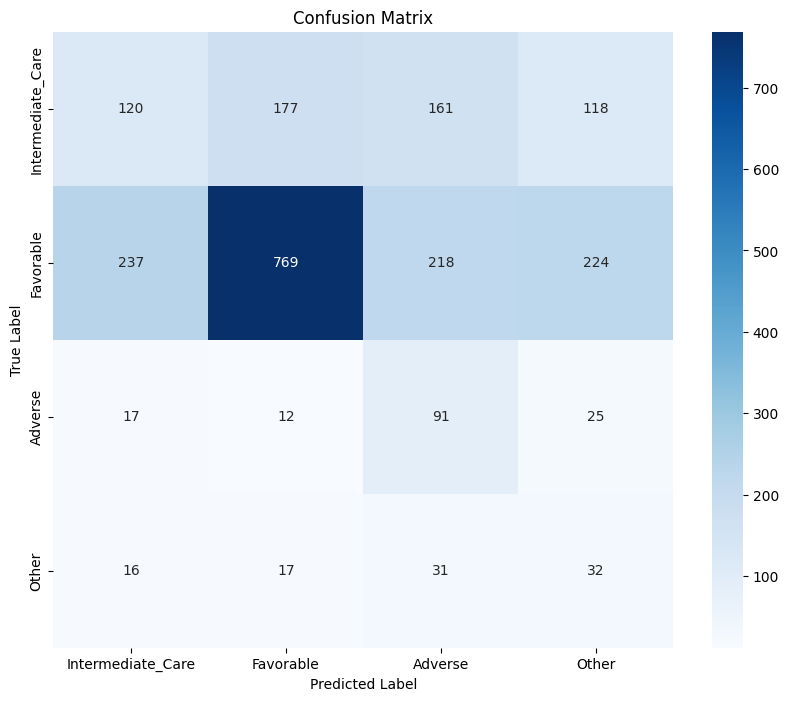

                   precision    recall  f1-score   support

Intermediate_Care       0.31      0.21      0.25       576
        Favorable       0.79      0.53      0.63      1448
          Adverse       0.18      0.63      0.28       145
            Other       0.08      0.33      0.13        96

         accuracy                           0.45      2265
        macro avg       0.34      0.43      0.32      2265
     weighted avg       0.60      0.45      0.49      2265



In [ ]:


# Evaluate with a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=outcome_mapping.keys(), yticklabels=outcome_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(all_labels, all_preds, target_names=outcome_mapping.keys()))



Further addition of batch norm , drop out and skip connections. Further improvement in Adverse event recall

## Future Work:



Explore combining Lab events and other features and unstructured data
  

Explore integrating additional data sources or using ensemble models for better performance.


Implement SHAP and LIME for detailed model interpretation to understand prediction drivers.
